In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import make_uniform, make_joint, normalize, update_norm, plot_contour, kde_from_pmf, update_norm_summary

In [3]:
df = pd.read_csv(Path.cwd() / 'data' / 'drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


In [4]:
grouped = df.groupby('Treatment')
responses = {}
for name, group in grouped:
    responses[name] = group['Response']
responses['Control'].head()

21    42
22    43
23    55
24    26
25    62
Name: Response, dtype: int64

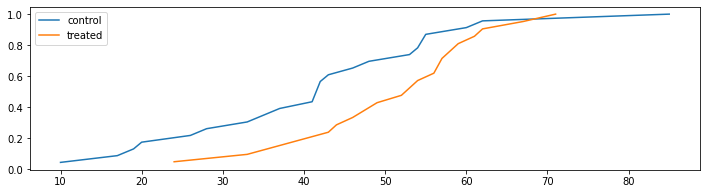

In [5]:
cdf_con = Cdf.from_seq(responses['Control'])
cdf_tr = Cdf.from_seq(responses['Treated'])
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
cdf_con.plot(ax=ax, label='control')
cdf_tr.plot(ax=ax, label='treated')
plt.legend()
plt.show()

In [6]:
qs_mu = np.linspace(20, 80, 101)
qs_sigma = np.linspace(5, 30, 101)
prior_mu = make_uniform(qs_mu, name='mean')
prior_sigma = make_uniform(qs_sigma, name='mean')
prior = make_joint(prior_mu, prior_sigma)
prior

,20.0,20.6,21.2,21.8,22.4,23.0,23.6,24.2,24.8,25.4,...,74.6,75.2,75.8,76.4,77.0,77.6,78.2,78.8,79.4,80.0
5.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.50,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.75,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
6.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
29.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
29.50,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
29.75,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


In [7]:
data = responses['Control']

In [8]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
mu_mesh.shape, sigma_mesh.shape, data_mesh.shape

((101, 101, 23), (101, 101, 23), (101, 101, 23))

In [9]:
densities = ss.norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

In [15]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

In [16]:
posterior = prior * likelihood
normalize(posterior)
posterior.shape

(101, 101)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


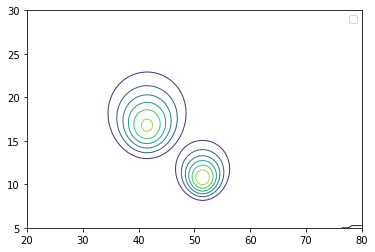

In [17]:
data_con = responses['Control']
data_tr = responses['Treated']
posterior_con = update_norm(prior, data_con)
posterior_tr = update_norm(prior, data_tr)
plot_contour(posterior_con)
plot_contour(posterior_tr)
plt.legend()

In [18]:
pmf_mean_con = Pmf(posterior_con.stack()).marginal(1)
pmf_mean_tr = Pmf(posterior_tr.stack()).marginal(1)
Pmf.prob_gt(pmf_mean_tr, pmf_mean_con)

0.9804790251873259

<AxesSubplot:>

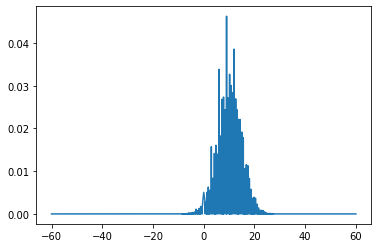

In [19]:
# sub_dist() 함수를 통해 차이의 분포 확인 가능 ↔ add_dist()
pmf_diff = Pmf.sub_dist(pmf_mean_tr, pmf_mean_con)
pmf_diff.plot()

<AxesSubplot:>

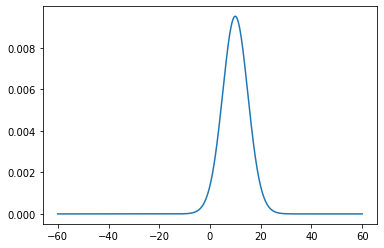

In [20]:
kde_diff = kde_from_pmf(pmf_diff, 1001)
kde_diff.plot()

In [22]:
kde_diff.head()

,probs
-60.00,9.624679e-24
-59.88,1.099329e-23
-59.76,1.254844e-23


In [23]:
pmf_diff.mean(), pmf_diff.credible_interval(0.9)

(9.954413088940848, array([ 2.4, 17.4]))

In [24]:
mu = 42
sigma = 17
n = 20
m = 41
s = 18

In [25]:
dist_m = ss.norm(mu, sigma/np.sqrt(n))
like1 = dist_m.pdf(m)
like1

0.10137915138497372

In [26]:
# MLE의 경우 n을, 불편추정량의 경우 n-1을 곱하는 형태 → 상황에 따라 선택
chi = (n-1) * s**2 / sigma**2
dist_s = ss.chi2(n-1)
like2 = dist_s.pdf(chi)
like2

0.053647183494035355

In [27]:
# m과 s는 서로 독립 → Basu's theorum
like = like1 * like2
like

0.0054387059368192735

In [28]:
summary = {}
for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

In [29]:
n_con, m_con, s_con = summary['Control']
n_tr, m_tr, s_tr = summary['Treated']

In [30]:
mus, sigmas = np.meshgrid(prior.columns, prior.index)
like1 = ss.norm(mus, sigmas/np.sqrt(n_con)).pdf(m_con)
chis = (n_con-1) * s_con ** 2 / sigmas ** 2
like2 = ss.chi2(n_con-1).pdf(chis)
like = like1 * like2

In [33]:
posterior_con2 = prior * like
normalize(posterior_con2)

0.0003034931174175798

In [37]:
posterior_tr2 = update_norm_summary(prior, summary['Treated'])

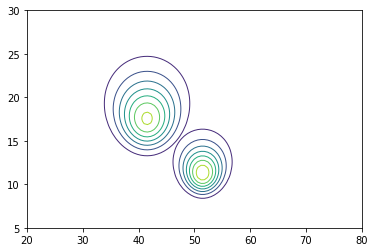

In [38]:
plot_contour(posterior_con2)
plot_contour(posterior_tr2)

In [39]:
pmf_mean_con2 = Pmf(posterior_con2.stack()).marginal(1)
pmf_mean_tr2 = Pmf(posterior_tr2.stack()).marginal(1)
Pmf.prob_gt(pmf_mean_tr, pmf_mean_con)

0.9804790251873259

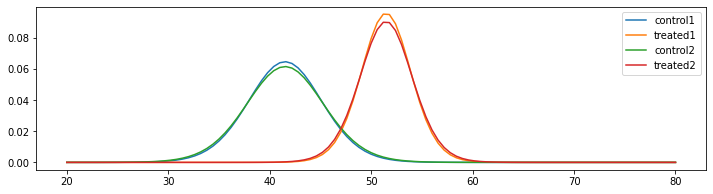

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
pmf_mean_con.plot(ax=ax, label='control1')
pmf_mean_tr.plot(ax=ax, label='treated1')
pmf_mean_con2.plot(ax=ax, label='control2')
pmf_mean_tr2.plot(ax=ax, label='treated2')
plt.legend()
plt.show()